In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
import matplotlib.pyplot as plt

/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# excel_filename = "data/filtered_fever_data.xlsx"
# df_filtered.to_excel(excel_filename, index=False)
df_filtered = pd.read_excel("../data/filtered_fever_data.xlsx")

In [5]:
# Calculate word counts per claim
word_counts = df_filtered['claim'].astype(str).apply(lambda x: len(x.split()))

# Get stats
average_words = word_counts.mean()
max_words = word_counts.max()
min_words = word_counts.min()

print(f"Average words per claim: {average_words:.2f}")
print(f"Max words in a claim: {max_words}")
print(f"Min words in a claim: {min_words}")


Average words per claim: 8.11
Max words in a claim: 65
Min words in a claim: 2


In [82]:
# Train-test split (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(df_filtered["claim"], df_filtered["label"], test_size=0.2, random_state=42)

### 1. TF-IDF Vectorization ###

In [83]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range = (1,3))
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [84]:
# Train and evaluate Naive Bayes model
model_tfidf = MultinomialNB(alpha = 1)
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# print("\n=== TF-IDF Model Performance ===")
# print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
# print(classification_report(y_test, y_pred_tfidf))


In [85]:
# Evaluate the model
print("\n=== TF-IDF Model Performance ===")
accuracy = round(accuracy_score(y_test, y_pred_tfidf), 5)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred_tfidf, digits=5))

print("EDA and Fake News Classification completed successfully!")


=== TF-IDF Model Performance ===
Accuracy: 0.76077
Classification Report:
              precision    recall  f1-score   support

     REFUTES    0.80739   0.17015   0.28106      6036
    SUPPORTS    0.75790   0.98462   0.85651     15926

    accuracy                        0.76077     21962
   macro avg    0.78265   0.57738   0.56879     21962
weighted avg    0.77150   0.76077   0.69836     21962

EDA and Fake News Classification completed successfully!


In [86]:
y_proba = model_tfidf.predict_proba(X_test_tfidf)[:, 1]
roc_auc = round(roc_auc_score(y_test, y_proba), 5)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.69306


<Figure size 640x480 with 0 Axes>

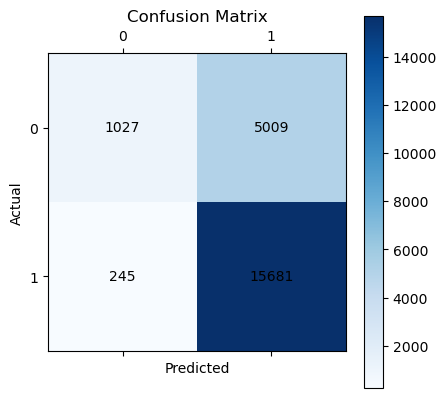

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred_tfidf)
plt.figure()
plt.matshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.grid(False)
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{value}', ha='center', va='center')
plt.show()

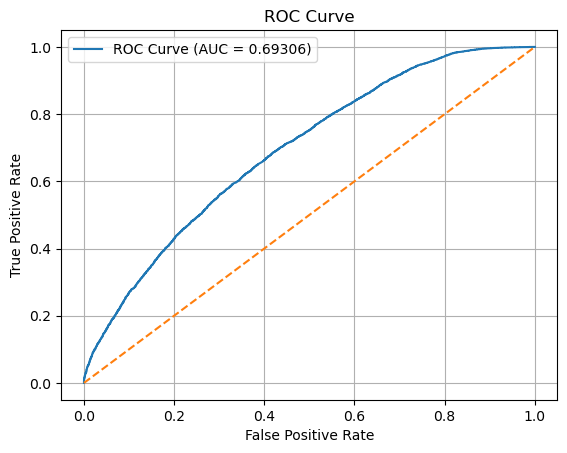

In [88]:
label_map = {'REFUTES': 0, 'SUPPORTS': 1}
y_test_bin = y_test.map(label_map)
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
roc_auc = round(roc_auc_score(y_test_bin, y_proba), 5)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()